In [1]:
import torch.optim as optim
from deepsplines.ds_modules import dsnn
import torch.nn as nn
import torch
import numpy as np
import wandb
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(1)
torch.manual_seed(1)
torch.set_default_dtype(torch.float)
device = torch.device('cpu' if torch.backends.mps.is_available() else 'mps')

In [3]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Deepsline California Housing",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.01,
    "architecture": "Deepline Linear",
    "dataset": "California Housing",
    "epochs": 1000,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: asg-animesh (animax_sg). Use `wandb login --relogin` to force relogin


In [4]:
from sklearn.datasets import fetch_california_housing
 
data = fetch_california_housing()
print(data.feature_names)
 
X, y = data.data, data.target
# Do more data analysis 

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [5]:
opt_params = {
    'size': 51, #knots k+2
    'range_': 6,
    'init': 'leaky_relu',
    'save_memory': False
}


In [18]:
class DeepSplines(dsnn.DSModule):
    def __init__(self,opt_params,epochs,lr):

        super(DeepSplines,self).__init__()
        self.model = nn.Sequential(
                        nn.Linear(8, 24),
                        dsnn.DeepBSpline('fc', 24, **opt_params),
                        nn.Linear(24, 12),
                        dsnn.DeepBSpline('fc', 12, **opt_params),
                        nn.Linear(12, 8),
                        dsnn.DeepBSpline('fc', 8, **opt_params),
                        nn.Linear(8, 1)
                    )
        self.initialization(opt_params['init'], init_type='He')
        self.num_params = self.get_num_params()
        self.epochs = epochs
        self.lr = lr
    
    def forward(self,x):
        return self.model(x)
    
    def fit(self,X,y):
        self.train()
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters_deepspline(), lr=self.lr)
        for epoch in range(self.epochs):
            optimizer.zero_grad()
            y_pred = self.forward(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            wandb.log({"loss": loss.item()}, step=epoch)
            if epoch % 100 == 0:
                print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
        return loss.item()
    
    def predict(self,X,y):
        self.eval()
        criterion = nn.MSELoss()
        with torch.no_grad():
            y_pred = self.forward(X)
        loss= criterion(y_pred, y)
        #print('test loss: {}'.format(loss.item()))
        return loss.item()



In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [8]:
model=DeepSplines(opt_params,epochs=2000,lr=1e-3)
wandb.init(
    # set the wandb project where this run will be logged
    project="Deepsline California Housing",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.01,
    "architecture": "Deepline Linear",
    "dataset": "California Housing",
    "epochs": 2000,
    }
)
wandb.watch(model,log= "all",log_freq=10)
loss_tr=model.fit(X_train,y_train)

Epoch 0: train loss: 986.0567016601562
Epoch 100: train loss: 1.3195732831954956
Epoch 200: train loss: 1.2657312154769897
Epoch 300: train loss: 1.2474550008773804
Epoch 400: train loss: 1.3091626167297363
Epoch 500: train loss: 1.2820892333984375
Epoch 600: train loss: 1.2571290731430054
Epoch 700: train loss: 1.2389861345291138
Epoch 800: train loss: 1.3086447715759277
Epoch 900: train loss: 1.2171610593795776
Epoch 1000: train loss: 1.2613348960876465
Epoch 1100: train loss: 1.2358717918395996
Epoch 1200: train loss: 1.2146563529968262
Epoch 1300: train loss: 1.2063889503479004
Epoch 1400: train loss: 1.3206666707992554
Epoch 1500: train loss: 2.940385103225708
Epoch 1600: train loss: 1.2650035619735718
Epoch 1700: train loss: 1.2276878356933594
Epoch 1800: train loss: 1.2508080005645752
Epoch 1900: train loss: 1.209648847579956


wandb: Network error (ConnectTimeout), entering retry loop.


In [11]:
K=[21,31,41,51,61,71]
R=[3,4,5,6,7]
best_loss=float('inf')
best_params=None
for k in K:
    for r in R:
        opt_params["size"]=k
        opt_params["range_"]=r
        model=DeepSplines(opt_params,epochs=2000,lr=1e-3)
        # wandb.init(
        #     # set the wandb project where this run will be logged
        #     project="Deepsline California Housing",
            
        #     # track hyperparameters and run metadata
        #     config={
        #     "learning_rate": 0.01,
        #     "architecture": "Deepline Linear",
        #     "dataset": "California Housing",
        #     "epochs": 2000,
        #     "k":k,
        #     "r":r
        #     }
        # )
        # wandb.watch(model,log= "all",log_freq=10)
        loss_tr=model.fit(X_train,y_train)
        loss_te=model.predict(X_test,y_test)
        print("k={},r={},train_loss={},test_loss={}".format(k,r,loss_tr,loss_te))
        if loss_te<best_loss:
            best_loss=loss_te
            best_params=opt_params

        
         

k=21,r=3,train_loss=1.2871395349502563,test_loss=1.285549521446228
k=21,r=4,train_loss=1.201987385749817,test_loss=1.1951178312301636
k=21,r=5,train_loss=1.3997913599014282,test_loss=1.385147213935852
k=21,r=6,train_loss=1.3284070491790771,test_loss=1.322401523590088
k=21,r=7,train_loss=1.3786813020706177,test_loss=1.3605108261108398
k=31,r=3,train_loss=1.3073337078094482,test_loss=1.2896579504013062
k=31,r=4,train_loss=1.122403621673584,test_loss=1.1014426946640015
k=31,r=5,train_loss=1.244877576828003,test_loss=1.2479361295700073
k=31,r=6,train_loss=1.3978228569030762,test_loss=1.3794398307800293
k=31,r=7,train_loss=1.3699613809585571,test_loss=1.3519688844680786
k=41,r=3,train_loss=1.291400671005249,test_loss=1.2936618328094482
k=41,r=4,train_loss=1.3351114988327026,test_loss=1.335227608680725
k=41,r=5,train_loss=1.2468366622924805,test_loss=1.2452056407928467
k=41,r=6,train_loss=1.2782878875732422,test_loss=1.2640329599380493
k=41,r=7,train_loss=1.18476140499115,test_loss=1.1831587

In [13]:
best_params["size"]=31
best_params["range_"]=4

In [30]:
model=DeepSplines(best_params,epochs=2000,lr=1e-3)

loss_tr=model.fit(X_train,y_train)

Epoch 0: train loss: 2513.556396484375
Epoch 100: train loss: 1.4562246799468994
Epoch 200: train loss: 1.3359140157699585
Epoch 300: train loss: 1.2898290157318115
Epoch 400: train loss: 1.2716360092163086
Epoch 500: train loss: 1.2649149894714355
Epoch 600: train loss: 1.261977195739746
Epoch 700: train loss: 1.2599565982818604
Epoch 800: train loss: 1.258320927619934
Epoch 900: train loss: 1.2567358016967773
Epoch 1000: train loss: 1.255059838294983
Epoch 1100: train loss: 1.2532647848129272
Epoch 1200: train loss: 1.2514355182647705
Epoch 1300: train loss: 1.2496604919433594
Epoch 1400: train loss: 1.2478723526000977
Epoch 1500: train loss: 1.2460802793502808
Epoch 1600: train loss: 1.2443007230758667
Epoch 1700: train loss: 1.2424368858337402
Epoch 1800: train loss: 1.2405461072921753
Epoch 1900: train loss: 1.2386189699172974


In [40]:
y_pred.reshape([6193]).shape

(6193,)

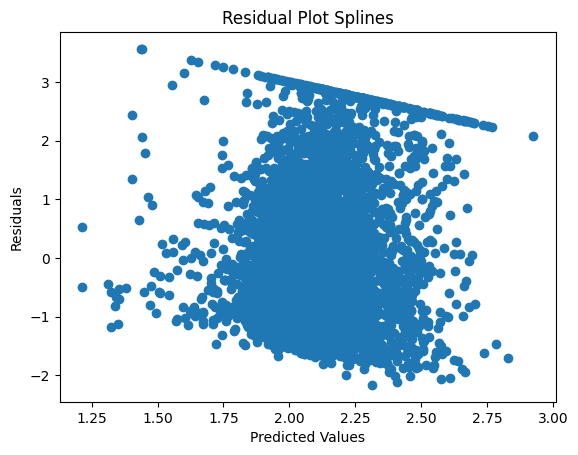

In [42]:
import matplotlib.pyplot as plt
y_pred=model.forward(X_test).detach().numpy().reshape([6193])
residuals = (y_test - y_pred).detach().numpy()
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot Splines')
plt.show()


1.2670626640319824

1.2882989645004272

ValueError: x and y must be the same size

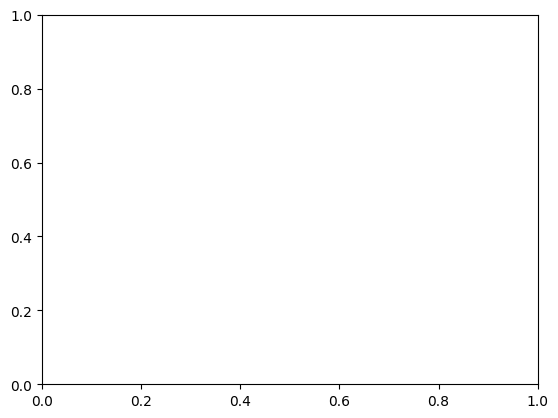

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten y_test to 1D array
y_test = y_test.ravel()

# Sort X_test and y_test by increasing values of X_test
sort_idx = np.argsort(X_test[:, 0])
X_test_sorted = X_test[sort_idx]
y_test_sorted = y_test[sort_idx]

# Plot fitted regression line
plt.scatter(X_test_sorted, y_test_sorted, color='blue', alpha=0.2, label='Test Data')
plt.plot(X_test_sorted[:, 0], model.forward(X_test_sorted), color='red', linewidth=2, label='Fitted Regression Line')
plt.xlabel('Median Income')
plt.ylabel('Median House Value')
plt.title('Fitted Regression Line for California Housing Prices')
plt.legend()
plt.show()


In [25]:
X_test.shape

torch.Size([6193, 8])

In [27]:
y_test.shape


torch.Size([6193, 1])